model based on https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/32402

In [1]:
import utils
from utils import *
%matplotlib inline
from sys import getsizeof

import keras
from keras.layers.merge import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)


In [2]:
target_size = (56,56)#(256, 256)

In [3]:
K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

### Load Data

In [4]:
x_train = []
y_train = []

df_train = pd.read_csv('data/train_v2.csv')
df_test = pd.read_csv('data/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

labels = ['blow_down',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'cultivation',
 'artisinal_mine',
 'haze',
 'primary',
 'slash_burn',
 'habitation',
 'clear',
 'road',
 'selective_logging',
 'partly_cloudy',
 'agriculture',
 'water',
 'cloudy']

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

### Load JPEG files

In [5]:

# for f, tags in tqdm(df_train.values, miniters=1000):
#     img = cv2.imread('data/train-jpg/{}.jpg'.format(f))
#     targets = np.zeros(17)
    
#     for t in tags.split(' '):
#         targets[label_map[t]] = 1 
        
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   
#     x_train.append(img)
#     y_train.append(targets)


In [6]:
# ## making num items good for divisions
# x_train.append(x_train[0])
# y_train.append(y_train[0])

In [7]:
# x_test = []

# for f, tags in tqdm(df_test.values, miniters=1000):
#     img = cv2.imread('data/test-jpg/{}.jpg'.format(f))
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   

#     x_test.append(cv2.resize(img, target_size))


In [8]:
# y_train = np.array(y_train, np.uint8)
# x_train = np.array(x_train, np.float32) #/ 255.
# x_test  = np.array(x_test, np.float32) #/ 255.

# #Transpose the data if using Theano

# x_train = x_train.transpose((0, 3, 1, 2))
# x_test = x_test.transpose((0, 3, 1, 2))





In [9]:
# save_array("data/cache/xtrain_100x100.dat",x_train)
# save_array("data/cache/xtest_100x100.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# save_array("data/cache/xtrain_112x112.dat",x_train)
# save_array("data/cache/xtest_112x112.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# save_array("data/cache/xtrain_56x56.dat",x_train)
# save_array("data/cache/xtest_56x56.dat",x_test)

In [10]:
x_train = load_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[1]))
y_train = load_array("data/cache/ytrain.dat")


In [11]:
# x_test = load_array("data/cache/xtest_100x100.dat")


In [12]:
x_train[:,0,:,:].mean(), x_train[:,1,:,:].mean(),x_train[:,2,:,:].mean()

(80.3116, 87.739105, 77.102135)

In [13]:
print(x_train.shape)
# print(x_test.shape)
print(y_train.shape)


(40480, 3, 56, 56)
(40480, 17)


In [89]:
# img = x_train[4]
# plt.imshow(np.rot90(img).transpose(1,2,0))

In [90]:
# np.rot90(img).shape

In [87]:
# tmp = img.transpose(1,2,0)
# plt.imshow(tmp.transpose(1,0,2))

In [84]:
# plt.imshow(img[:, :,::-1].transpose(1,2,0))
# plt.imshow(np.rot90(tmp))

### Making a sample

In [14]:
np.random.seed(2089)

perm = np.random.permutation(len(x_train))
idx_sample = perm[:int(len(x_train)*0.5)]

x_sample = x_train[idx_sample]
y_sample = y_train[idx_sample]

x_sample.shape, y_sample.shape

((20240, 3, 56, 56), (20240, 17))

In [15]:
# x_train_flips_sample = [x_sample[:,:,::-1,:],x_sample[:,:,:,::-1],x_sample[:,:,::-1,::-1]]

### Model Training 


In [16]:
# stretch_n(x_train[851].transpose(1,2,0)).transpose(2,0,1).shape

In [16]:
# plt.imshow(stretch_n(x_train[851].transpose(1,2,0)))

In [15]:
channel_means = np.array([80.301086, 87.727798, 77.089554], dtype=np.float32).reshape((3,1,1))

def preprocess(x):
    return x - channel_means
#     return x/255.0

In [16]:
def make_conv_bn_relu(x,num_layers,num_filters,kernel_size):
    
    for _ in range(num_layers):
    
        x = Convolution2D(num_filters,kernel_size,padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Activation(activation="relu")(x)
    
    return x

In [17]:
def make_bottleneck(x,num_filters,double_output_filters=True):
    
    x = Convolution2D(num_filters,1,padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation(activation="relu")(x)

    
    x = Convolution2D(num_filters,3,padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation(activation="relu")(x)
    
    
    if double_output_filters:
        x = Convolution2D(num_filters*2,1,padding='same')(x)
    else:
        x = Convolution2D(num_filters,1,padding='same')(x)

    x = BatchNormalization(axis=1)(x)
    x = Activation(activation="relu")(x)
    

    return x 

In [12]:
def make_shortcut_layer(x,num_filters):
    x = Convolution2D(num_filters,1,padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation(activation="relu")(x)
    
    return x


In [21]:
#10 minutes per epoch, 0.88 val loss
def create_model():
    model_input = Input(shape=(3,target_size[0],target_size[1]))
    
    #preprocess
#     x = Lambda(preprocess,output_shape=(3,)+target_size)(model_input)
    x = make_conv_bn_relu(model_input,3,16,(1,1))
    
    
    down1 = make_bottleneck(x,32)
    x  = MaxPooling2D(padding='same')(down1)
    flat1a = x# Flatten()(x)

    
    #2
    down2 = add([make_bottleneck(x,64), # 64 > 128
                make_shortcut_layer(x,128)])    
    x = MaxPooling2D(padding='same')(down2)
    flat2a = x# Flatten()(x)
    
    #3
    down3 = add([make_bottleneck(x,128), # 128 > 256
                make_shortcut_layer(x,256)])    
    x = MaxPooling2D(padding='same')(down3)
    flat3a = x# Flatten()(x)

    
    
    
    
    up3 = UpSampling2D(size=(2, 2))(x)
    up3 = add([up3,down3])   # (256,28,28)x2
    x = make_bottleneck(up3,128,False)
    flat3 = MaxPooling2D(padding='same')(x) # Flatten()(MaxPooling2D(padding='same')(x))
    
    
    up2 = UpSampling2D(size=(2, 2))(x) #128,56,56
    up2 = add([up2,down2])
    x = make_bottleneck(up2,64,False)
    flat2 = MaxPooling2D(padding='same')(x)#Flatten()(MaxPooling2D(padding='same')(x))
    
    
    up1 = UpSampling2D(size=(2, 2))(x) #64,112,112
    up1 = add([up1,down1])
    x = make_bottleneck(up1,64,False)
    flat1 = MaxPooling2D(padding='same')(x) #Flatten()(MaxPooling2D(padding='same')(x))

    
    
    all_max_features = concatenate([GlobalAveragePooling2D()(flat1a),
                GlobalAveragePooling2D()(flat2a),
                GlobalAveragePooling2D()(flat3a),
                GlobalAveragePooling2D()(flat1),
                GlobalAveragePooling2D()(flat2),
                GlobalAveragePooling2D()(flat3)])
#                 GlobalAveragePooling2D()(max4)
    
    x = Dense(512,activation='relu')(all_max_features)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(17,activation='sigmoid')(x)
    
    
    return Model(inputs=model_input, outputs=x)
    




    

In [18]:

#3 minutes per epoch, 0.914 F2 score, 0.1094 val loss

def simple_net():
    model_input = Input(shape=(3,target_size[0],target_size[1]))
    
    #preprocess
    x = Lambda(preprocess,output_shape=(3,)+target_size)(model_input)
    x = make_conv_bn_relu(x,3,16,(1,1))
    
    
    
    x = make_bottleneck(x,32)
    max1  = MaxPooling2D(padding='same')(x)
    
    x = make_bottleneck(max1,64)
    max2  = MaxPooling2D(padding='same')(x)
    
    x = make_bottleneck(max2,128,False)
    max3  = MaxPooling2D(padding='same')(x)

#     x = make_bottleneck(max3,256,False)
#     max4  = MaxPooling2D(padding='same')(x)

        
    all_avg_features = concatenate([GlobalAveragePooling2D()(max1),
                GlobalAveragePooling2D()(max2),
                GlobalAveragePooling2D()(max3)])
    
#     all_max_features = concatenate([GlobalMaxPooling2D()(max1),
#             GlobalMaxPooling2D()(max2),
#             GlobalMaxPooling2D()(max3)])
    

        
    #,GlobalAveragePooling2D()(max4)
    
    x = Dense(512,activation='relu')(all_avg_features)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    
#     x = Dense(17,activation='sigmoid')(x)
    weather_output = Dense(4,activation='softmax',name="weather")(x)
    rare_class_output = Dense(13,activation='sigmoid',name="rareclass")(x)
    
    return Model(inputs=model_input, outputs=[weather_output,rare_class_output])
   

In [26]:

def simple_net_with_residuals():
    model_input = Input(shape=(3,target_size[0],target_size[1]))
    
    #preprocess
    x = Lambda(preprocess,output_shape=(3,)+target_size)(model_input)
    x = make_conv_bn_relu(x,3,16,(1,1))
    
    
    
    x = add([make_bottleneck(x,32),make_shortcut_layer(x,64)])
    max1  = MaxPooling2D(padding='same')(x)
    
    x = add([make_bottleneck(max1,64),make_shortcut_layer(max1,128)])
    max2  = MaxPooling2D(padding='same')(x)
    
    x = add([make_bottleneck(max2,128,False), make_shortcut_layer(max2,128)])
    max3  = MaxPooling2D(padding='same')(x)

#     x = make_bottleneck(max3,256,False)
#     max4  = MaxPooling2D(padding='same')(x)

        
    all_max_features = concatenate([GlobalAveragePooling2D()(max1),
                GlobalAveragePooling2D()(max2),
                GlobalAveragePooling2D()(max3)])
#                 GlobalAveragePooling2D()(max4)
    
    x = Dense(512,activation='relu')(all_max_features)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(17,activation='sigmoid')(x)
    
    
    return Model(inputs=model_input, outputs=x)
   

In [21]:
def preprocess_and_flip(x):
    
    x = x - channel_means
#     width = target_size[0]
#     print x.shape[0]
    
#     all_flipped = np.zeros((batch_size,3,width*2,width*2)).astype(np.float16)
    
    t1 = K.concatenate([x, x[:,:,:,::-1]], axis=2)
    t2 = K.concatenate([x[:,:,::-1,:],x[:,:,::-1,::-1]], axis=2)
    
#     all_flipped[:,:,:width,:width] = x
#     all_flipped[:,:,:width,width:] = x[:,:,::-1,:]
#     all_flipped[:,:,width:,:width] = x[:,:,:,::-1]
#     all_flipped[:,:,width:,width:] = x[:,:,::-1,::-1]
    
#     return K.concatenate([x, x[:,:,::-1,:],x[:,:,:,::-1],x[:,:,::-1,::-1]], axis=0)
    return K.concatenate([t1,t2], axis=3)

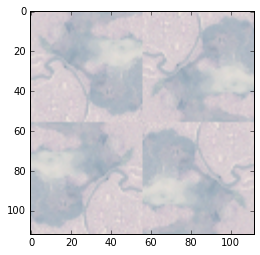

In [141]:
# plt.imshow(preprocess_and_flip(x_train[10].reshape(1,3,56,56))[0].transpose(1,2,0))
# plt.imshow(x_train[10].transpose(1,2,0))

In [22]:
#http://benanne.github.io/2015/03/17/plankton.html


def simple_net_roi_innetwork_exapnsion():
    model_input = Input(shape=(3,target_size[0],target_size[1]))
    
    #preprocess
    x = Lambda(preprocess_and_flip,output_shape=(3,target_size[0]*2,target_size[1]*2))(model_input)
    x = make_conv_bn_relu(x,3,16,(1,1))
    
    
    
    x = make_bottleneck(x,32)
    max1  = MaxPooling2D(padding='same')(x)
    
    x = make_bottleneck(max1,64)
    max2  = MaxPooling2D(padding='same')(x)
    
    x = make_bottleneck(max2,128,False)
    max3  = MaxPooling2D(padding='same')(x)

#     x = make_bottleneck(max3,256,False)
#     max4  = MaxPooling2D(padding='same')(x)

        
    all_avg_features = concatenate([GlobalAveragePooling2D()(max1),
                GlobalAveragePooling2D()(max2),
                GlobalAveragePooling2D()(max3)])
    
#     all_max_features = concatenate([GlobalMaxPooling2D()(max1),
#             GlobalMaxPooling2D()(max2),
#             GlobalMaxPooling2D()(max3)])
    

        
    #,GlobalAveragePooling2D()(max4)
    
    x = Dense(512,activation='relu')(all_avg_features)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(17,activation='sigmoid')(x)
    
    
    return Model(inputs=model_input, outputs=x)
   

In [15]:
# simple_net_roration_invariant().summary()

In [16]:
# tmp = simple_net_roi_innetwork_exapnsion()
# tmp.summary()
# del tmp

### Quick training and prediction (on SAMPLE data)

In [19]:
VALIDATION_SPLIT = 0.1
np.random.seed(2089)

perm = np.random.permutation(len(x_sample))
idx_train = perm[:int(len(x_sample)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(x_sample)*(1-VALIDATION_SPLIT)):]

In [20]:
X_train = x_sample[idx_train]
X_valid = x_sample[idx_val]


Y_train = y_sample[idx_train]
Y_valid = y_sample[idx_val]


# oleg_sample_train = oleg_sample[idx_train]
# oleg_sample_valid = oleg_sample[idx_val]

# mahotas_sample_train = mahotas_sample[idx_train]
# mahotas_sample_valid= mahotas_sample[idx_val]

In [52]:
# X_train.shape


In [21]:
from ImageDataGenerator_extended2 import *


batch_size = 256


train_gen = ImageDataGenerator_Multioutput5( 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)



train_batch = train_gen.flow(X_train,Y_train,batch_size=batch_size,shuffle=True)


In [39]:
# train_batch = train_gen.flow(X_train,Y_train,batch_size=256,shuffle=True)


--- 


In [23]:
model =  simple_net()
model.load_weights("weights/simplenet_BN_relu_56_trainx4_multioutput.h5")

In [28]:

kfold_weights_path = os.path.join('weights/', 'simplenet_BN_relu_56_trainx4_multioutput.h5')


#              ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-7)
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',  patience=2, verbose=1, factor=0.5, min_lr=1e-5)

            ]



In [29]:

model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# end_to_end.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# fcn_plus_feats_model.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

Training

In [24]:
weather_indices = [label_map["cloudy"],label_map["haze"],label_map["partly_cloudy"],label_map["clear"]]
rare_class_indices = [x for x in np.arange(17) if (x not in weather_indices)]


In [ ]:
# batch_size = 128
## FCN

# history = model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)


## FCN+features  

# history = fcn_plus_feats_model.fit(x = [conv_trn_feat,mahotas_sample_train], y= Y_train, 
#                                    validation_data=([conv_valid_feat,mahotas_sample_valid], Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)


## end-to-end
#     history = end_to_end.fit_generator(train_batch, steps_per_epoch=len(X_train)/batch_size,
#                                        validation_data=(X_valid, Y_valid),
#                                        epochs=1,callbacks=callbacks)


# history = model.fit_generator(train_batch, validation_data=(X_valid, Y_valid),
#                                steps_per_epoch=2*len(X_train)/batch_size,epochs=50,callbacks=callbacks)

history = model.fit_generator(train_batch, 
                               validation_data=(X_valid,[Y_valid[:,weather_indices],Y_valid[:,rare_class_indices]]),
                               steps_per_epoch=2*len(X_train)/batch_size,epochs=50,callbacks=callbacks)




#### verifying results

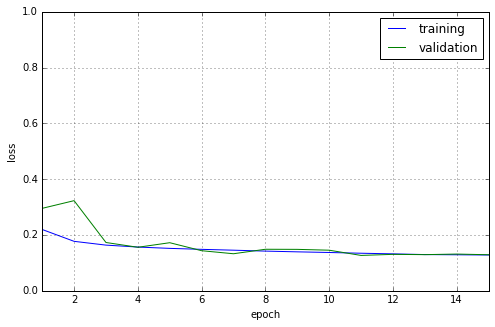

In [30]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

In [29]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print 'Minimum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss)

max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print 'Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc)

Minimum loss at epoch 5 = 0.1083
Maximum accuracy at epoch 5 = 0.9589


In [75]:

if os.path.isfile(kfold_weights_path):
    print "loading best weights from '{}'".format(kfold_weights_path)
    model.load_weights(kfold_weights_path)
    
    

loading best weights from 'weights/simplenet_BN_relu_56_trainx4.h5'


In [25]:
preds_val = model.predict(X_valid)


In [77]:
print('F2 Score:', f2_score(Y_valid, preds_val>0.08))

('F2 Score:', 0.90211491312958847)


In [78]:
thres = optimise_f2_thresholds(Y_valid, preds_val)
np.mean(thres)

(0, 0.16, 0.91521370145402992)
(1, 0.25, 0.91535214827415223)
(2, 0.23, 0.91536515014642195)
(3, 0.11, 0.91542106827245528)
(4, 0.24, 0.91591939400314726)
(5, 0.13, 0.91591939400314726)
(6, 0.31, 0.91671554975438385)
(7, 0.26, 0.9170439947777399)
(8, 0.12, 0.91706665451222991)
(9, 0.23, 0.91717819542832524)
(10, 0.11, 0.91878005580174016)
(11, 0.24, 0.91910689272151591)
(12, 0.1, 0.91948550631174386)
(13, 0.23, 0.91984598249457472)
(14, 0.16, 0.92020273093446681)
(15, 0.21, 0.92030089737034038)
(16, 0.18, 0.92060888977319444)


0.19235294117647059

simple net: ('F2 Score:', 0.91429801936143507)

simple net with residuals: ('F2 Score:', 0.90490633323372127)

simn with roi? ('F2 Score:', 0.903


('F2 Score:', 0.90490633323372127)


depth 256, normalize input by /255: ('F2 Score:', 0.89648641491867431)

concatenating global max and global avg is stuck around 0.93 accuracy and 0.15 val loss, early termination 


Relu after batch norm ('F2 Score:', 0.91422310026204201) but better validation score

with 56x56, Relu,BN: ('F2 Score:', 0.91427022590403428)

flipped x 4: ('F2 Score:', 0.91224325576890486) 0.1083 

2x augmentation ('F2 Score:', 0.92060888977319444)

In [79]:
print('F2 Score:', f2_score(Y_valid, preds_val>thres))

('F2 Score:', 0.92060888977319444)


In [28]:
def optimise_f2_thresholds2(y, p, verbose=True, resolution=100,num_classes=17):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(num_classes):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.01]*num_classes
    for i in range(num_classes):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            threshold = float(i2) / resolution
            x[i] = threshold
            score = mf(x)
            if score > best_score:
                best_i2 = threshold
                best_score = score

        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [29]:
thres = optimise_f2_thresholds2(Y_valid[:,rare_class_indices], preds_val[1],num_classes=13)


(0, 0.05, 0.71364666551823353)
(1, 0.18, 0.72401827217656078)
(2, 0.21, 0.72477419726820258)
(3, 0.09, 0.73412189073576306)
(4, 0.3, 0.74655132678329128)
(5, 0.09, 0.74836270306122066)
(6, 0.0, 0.74863718703135673)
(7, 0.12, 0.75475478755100545)
(8, 0.27, 0.76577651689872639)
(9, 0.24, 0.77962273844752472)
(10, 0.26, 0.78612693807981149)
(11, 0.28, 0.80646013998970811)
(12, 0.16, 0.86034011435291979)


In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

p = encoder.fit_transform(np.argmax(preds_val[0],axis=1).reshape(-1,1)).toarray().astype(bool)


In [31]:
combined_val_preds = np.zeros((Y_valid.shape[0],17))
combined_val_preds[:,weather_indices] = p
combined_val_preds[:,rare_class_indices] = preds_val[1]>thres

In [32]:
print('F2 Score:', f2_score(Y_valid, combined_val_preds))

('F2 Score:', 0.89813172884639669)


### Making Prediction

In [46]:
#clear memory
del x_train, X_train, X_valid #, conv_trn_feat, conv_valid_feat
x_test = load_array("data/cache/xtest_56x56.dat")


In [45]:
# oleg_test = load_array("data/cache/oleg_test")
# oleg_test = oleg_test[:,2:]

In [47]:
# mahotas_test = load_array("data/cache/mahotas_14_jpg_test.dat")

In [81]:
preds = make_staged_predictions(model,num_parts=5,nb_aug=4)
# preds = make_staged_predictions_with_features(model=model,data=x_test, features=mahotas_test,num_parts=5,do_augmentation=False)

data has shape:  (61191, 3, 56, 56)
breaking data into chunks of  12238
augmentation round 1 of 4
predicting part 1 of 5
items needed vs. items generated:  12238 12238
predicting part 2 of 5
items needed vs. items generated:  12238 12238
predicting part 3 of 5
items needed vs. items generated:  12238 12238
predicting part 4 of 5
items needed vs. items generated:  12238 12238
predicting part 5 of 5
items needed vs. items generated:  12238 12238
predicting part 6 of 5
items needed vs. items generated:  1 1
augmentation round 2 of 4
predicting part 1 of 5
items needed vs. items generated:  12238 12238
predicting part 2 of 5
items needed vs. items generated:  12238 12238
predicting part 3 of 5
items needed vs. items generated:  12238 12238
predicting part 4 of 5
items needed vs. items generated:  12238 12238
predicting part 5 of 5
items needed vs. items generated:  12238 12238
predicting part 6 of 5
items needed vs. items generated:  1 1
augmentation round 3 of 4
predicting part 1 of 5
ite

In [82]:
save_array("data/cache/preds_simplenet_2xaug_samplex4xttaug.dat",preds)

In [80]:
def make_staged_predictions(model,num_parts, nb_aug=1):
    partial_preds = []

    data = load_array("data/cache/xtest_{}x{}.dat".format(target_size[0],target_size[0]))

    chunck_size = len(data)/num_parts

    print "data has shape: ", data.shape
    print "breaking data into chunks of ", chunck_size
    
    
    augmented_predictions = np.zeros((data.shape[0],17)).astype(np.float16)

    for n in range(nb_aug):
        print "augmentation round {} of {}".format(n+1,nb_aug) 
        partial_preds = []
        batch_size = 128.0

        for i in range(1,num_parts+2):
            print "predicting part {} of {}".format(i,num_parts)      

            start_index = (i-1)*chunck_size
            end_index = min(len(data),i*chunck_size)
            num_items = end_index-start_index

            test_batch = train_gen.flow(data[start_index:end_index],batch_size=int(batch_size),shuffle=False)
            pp = model.predict_generator(test_batch,steps=math.ceil(num_items/batch_size), verbose=0)

            print "items needed vs. items generated: ",num_items,len(pp) 
            
            partial_preds.append(pp)


        augmented_predictions += np.vstack(partial_preds)

    augmented_predictions /= (nb_aug) 
    return augmented_predictions

    

### Make submission

In [6]:
preds = load_array("data/cache/preds_simplenet_2xaug_5xtaug.dat")
thres = load_array("data/cache/simplenet_thres.dat")

In [7]:
preds.shape

(61191, 17)

In [8]:
result = pd.DataFrame(preds, columns = labels)
result.head(1)

,blow_down,bare_ground,conventional_mine,blooming,cultivation,artisinal_mine,haze,primary,slash_burn,habitation,clear,road,selective_logging,partly_cloudy,agriculture,water,cloudy
0,0.000596,0.000028,0.0,0.021454,0.00177,0.0,0.001017,1.0,3.576279e-07,0.000718,0.995117,0.001883,0.001562,0.001007,0.004765,0.003437,0.0


In [9]:
test_medians = result.median().values

In [88]:
# thres

In [10]:
test_medians - thres

array([-0.1198, -0.1794, -0.17  , -0.1094, -0.1874, -0.29  , -0.2075,  0.8989, -0.15  , -0.1863,
        0.749 , -0.1733, -0.1896, -0.3567, -0.1074, -0.1472, -0.07  ], dtype=float16)

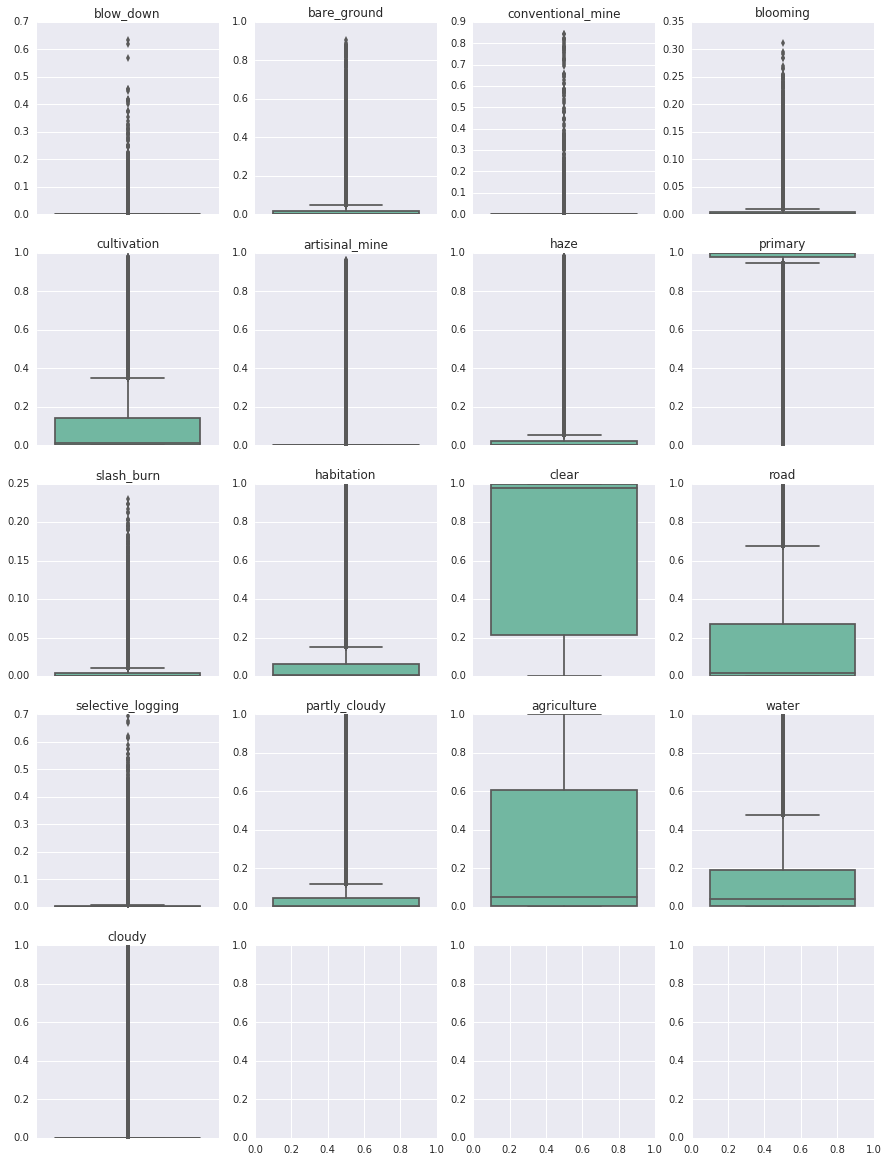

In [11]:
import seaborn as sns
tags_pred = np.array(preds).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels[i])


In [12]:
from tqdm import tqdm_notebook

In [13]:
label_preds = []
for i in tqdm_notebook(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    label_preds.append(' '.join(list(a.index)))

In [15]:
df_test["tags"] = label_preds
df_test.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy cloudy


In [16]:
submission_file = 'subm/simplenet_full_35aug.csv'
df_test.to_csv(submission_file, index=False)
FileLink(submission_file)

/home/ubuntu/planet/subm/simplenet_full_35aug.csv